In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, OPTForCausalLM
from tqdm import tqdm 

model = AutoModelForCausalLM.from_pretrained('/workspace/Weight_compression/Wparam_dataset/hf_model/facebook--opt-6.7b')

Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  9.67it/s]


In [16]:
import json
path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Meta-Llama-3-8B/ql_ldlq128_rnorm_ft_ft/lmbda30/config.json'
path = '/workspace/Weight_compression/hf_model_comp/comp_qtip/ckpt/meta-llama--Meta-Llama-3-8B/ql_ldlq128_rnorm_ft_ft/lmbda30/config.pt'
# with open(path) as f:
#     c = json.load(f)

c = torch.load(path, weights_only = False)
model_config = c['model_config']
hasattr(model_config, 'comp_params') and model_config.comp_params.get('ft_rnorm')


True

True

In [3]:
import torch

# 랜덤 텐서 생성
m, n = 8, 4
W = torch.randn(m, n, requires_grad=True)
H = torch.randn(n, n)
H = H @ H.T  # 대칭 positive semi-definite matrix

# diff 정의
target = 0.5 * W
diff = W - target  # 예시

# 원래 방식: trace(diff @ H @ diff.T)
loss_trace = torch.trace(diff @ H @ diff.T) / torch.trace(W @ H @ W.T)

# 개선 방식: sum-based
numerator = torch.sum((H @ diff.T) * diff.T)
denominator = torch.sum((H @ W.T) * W.T)
loss_sum = numerator / denominator

# 비교
print("Are the two losses close? ", torch.allclose(loss_trace, loss_sum, atol=1e-6))
print("Are the two losses close? ", torch.equal(loss_trace, loss_sum))
print("Loss (trace):", loss_trace.item())
print("Loss (sum):  ", loss_sum.item())

# gradient 검증
loss_sum.backward()
print("W.grad is not None:", W.grad is not None)


Are the two losses close?  True
Are the two losses close?  True
Loss (trace): 0.25
Loss (sum):   0.25
W.grad is not None: True


In [1]:
import argparse
import os
import time

import glog, json

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

import torch
import torch.multiprocessing as mp
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_attn_mask_utils import \
    _prepare_4d_causal_attention_mask

from lib import utils
from lib.algo import finetune
from lib.codebook import bitshift
from operator import attrgetter

import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

from NWC.models import get_model

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


config = os.path.join(os.path.dirname(comp_model_path), 'config.json')
with open(config, 'r', encoding='utf-8') as file:
    config = json.load(file)
config = Config(**config)

shift, scale = None, None
if config.architecture == 'nwc_ql' and not hasattr(config, "Q"):
    config.Q = 4
if not hasattr(config, "no_layernorm"):
    config.no_layernorm = False
    
comp_model = get_model(config.architecture, config, scale=scale, shift=shift)      
ckpt = torch.load(comp_model_path, weights_only=False)
if True:
    try:
        scale = ckpt["state_dict"]["scale"]
        shift = ckpt["state_dict"]["shift"]
        print('Use train scale and shift')
        print('shift: ', shift, ' scale:', scale)
    except:
        scale, shift  = torch.zeros(1), torch.zeros(1)
else:
    if 'scale' in ckpt["state_dict"]:
        del ckpt["state_dict"]['scale']
    if 'shift' in ckpt["state_dict"]:
        del ckpt["state_dict"]['shift']
    shift, scale = utils.get_model_weight_stats(model, args, config.input_size)
print('shift: ', shift, ' scale:', scale)

comp_model.load_state_dict(ckpt["state_dict"], strict = False)
comp_model.scale = scale
comp_model.shift = shift
comp_model.eval()
comp_model.update()

W0529 06:04:32.891287 300632 warnings.py:109] /opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

I0529 06:04:33.633925 300632 utils.py:146] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
I0529 06:04:33.635121 300632 utils.py:149] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
I0529 06:04:33.635999 300632 utils.py:162] NumExpr defaulting to 16 threads.
I0529 06:04:33.885770 300632 config.py:54] PyTorch version 2.6.0 available.
W0529 06:04:36.215152 300632 warnings.py:109] /opt/conda/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @am

NameError: name 'comp_model_path' is not defined

In [104]:
def load_comp_model(comp_model_path, args=None):
    # config 로딩
    config_path = os.path.join(os.path.dirname(comp_model_path), 'config.json')
    with open(config_path, 'r', encoding='utf-8') as f:
        config_data = json.load(f)
    config = Config(**config_data)

    # 기본값 설정
    if config.architecture == 'nwc_ql' and not hasattr(config, "Q"):
        config.Q = 4
    if not hasattr(config, "no_layernorm"):
        config.no_layernorm = False

    shift, scale = None, None
    comp_model = get_model(config.architecture, config, scale=scale, shift=shift)

    # checkpoint 로딩
    ckpt = torch.load(comp_model_path, weights_only=False)

    # scale / shift 로드 (있으면 사용)
    # try:
    #     scale = ckpt["state_dict"]["scale"]
    #     shift = ckpt["state_dict"]["shift"]
    #     print('Use train scale and shift')
    #     print('shift: ', shift, ' scale:', scale)
    # except KeyError:
    #     if args is not None:
    #         shift, scale = utils.get_model_weight_stats(comp_model, args, config.input_size)
    #     else:
    
    shift, scale = torch.zeros(1), torch.ones(1)

    print('Final shift: ', shift, ' Final scale:', scale)

    # 모델에 state_dict 로딩
    comp_model.load_state_dict(ckpt["state_dict"], strict=False)
    comp_model.scale = scale
    comp_model.shift = shift
    comp_model.eval()
    comp_model.update()

    return comp_model


Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])


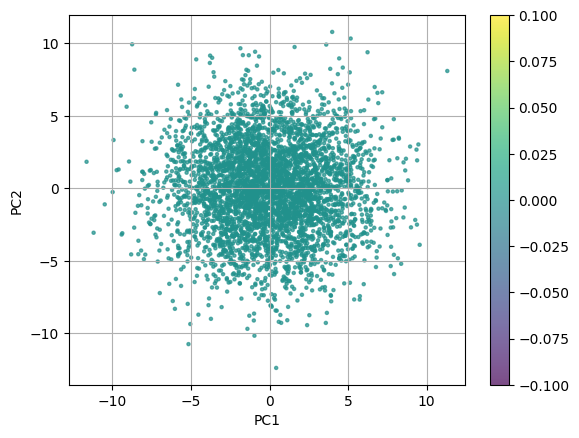

In [105]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

W = torch.randn(1, 4096, 16).cuda()
W = W * 3
# a = 1.5
# W = (torch.rand(1, 4096, 16) * 2 * a - a).cuda()  # Uniform(-0.1, 0.1)
# W = torch.zeros(1, 4096, 16)
# for a in [0.5, 1, 1.5, 2]:
#     W += torch.randn(1, 4096, 16)
# W = W.cuda()
ql = torch.zeros(1, 1, 1).to(int).cuda()
data = {}
data['weight_block'] = W
data['q_level'] = ql

comp_model_path = "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/M16/lmbda100_rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_4.42601_bpp_5.12872_MSE_0.0082_total_iter_95000.pth.tar"
comp_model_path2 = "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_gaussian__llama8b_col_1024.pt/rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/lmbda100_/best_loss_model_loss_11.4853_bpp_3.25516_MSE_0.01873_total_iter_82500.pth.tar"

models = []
for path in [comp_model_path, comp_model_path2]:
    model = load_comp_model(path).cuda()
    models.append(model)

W_hats = []
for model in models:
    model = load_comp_model(path).cuda()
    out = model(data)
    W_hat = out['x_hat'].reshape(W.shape)
    W_hats.append(W_hat)


mse = ((W_hats[0] - W)**2).detach().cpu()
mse2 = ((W_hats[1] - W)**2).detach().cpu()
# W = W.cpu()
# W_hat = W_hat.detach().cpu()

bs = 16
col_data = W.T.reshape(-1, bs).cpu().numpy()
col_pca = PCA(n_components=2).fit_transform(col_data)
col_mse_block = mse.T.reshape(-1, bs).mean(dim=1).cpu().numpy()
# col_mse_block = mse.T.reshape(-1, bs).mean(dim=1).cpu().numpy()
col_mse_block = mse.T.reshape(-1, bs).mean(dim=1).cpu().numpy()
col_mse_block2 = mse2.T.reshape(-1, bs).mean(dim=1).cpu().numpy()

col_mse_diff = col_mse_block - col_mse_block2

fig = plt.figure()
# fig, axes = plt.subplots(len(block_sizes), 6, figsize=(24, 4 * len(block_sizes)))
ax = fig.add_subplot(111)
sc = ax.scatter(col_pca[:, 0], col_pca[:, 1], s=5, alpha=0.7, c=col_mse_diff, cmap='viridis')
plt.colorbar(sc, ax=ax)  # 컬러바 추가
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True)
plt.show()

In [106]:
out

{'x': tensor([[[ 2.8415,  1.3480, -5.5071,  ...,  1.8466, -2.5827,  1.2457],
          [-0.1405,  2.5359,  3.9895,  ...,  3.1821, -0.2042,  0.6334],
          [-1.2917,  2.5605,  1.0402,  ..., -2.6934,  0.7256,  0.4379],
          ...,
          [ 8.4231,  0.0622, -1.3866,  ...,  1.5783, -3.1271,  4.7334],
          [-1.7176,  0.6769, -0.8590,  ...,  0.2689, -3.5388, -5.4220],
          [-0.2630,  1.3958,  2.6350,  ...,  4.8689, -3.0386,  6.1962]]],
        device='cuda:0'),
 'x_hat': tensor([[[[ 2.9381,  1.1451, -5.5731,  ...,  1.8576, -2.3167,  1.1956],
           [-0.1680,  2.4747,  3.9036,  ...,  2.9403, -0.0211,  0.4375],
           [-1.1797,  1.9488,  1.1509,  ..., -2.6158,  0.9722,  0.0799],
           ...,
           [ 8.2123,  0.1475, -1.2679,  ...,  1.5200, -2.9335,  4.7685],
           [-1.8282,  0.5009, -0.6060,  ...,  0.2506, -3.2747, -5.3326],
           [-0.3401,  1.0632,  2.3468,  ...,  4.6641, -2.8759,  6.1984]]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 'li

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import math
# a 값 수정: 0부터 20까지 예를 들어 10단계로
a_values = np.arange(0.1, 60, 0.1)  # 0은 제외 (나눗셈 문제 방지)

comp_model_paths =[
    "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_gaussian__llama8b_col_1024.pt/rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/lmbda100_/best_loss_model_loss_11.4853_bpp_3.25516_MSE_0.01873_total_iter_82500.pth.tar",
    "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Llama-2-7b-hf__droplast_col_1024.pt/rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/lmbda100_/best_loss_model_loss_11.42767_bpp_3.22887_MSE_0.01908_total_iter_82500.pth.tar",
    "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_gaussian_padding.pt/M16/lmbda100_rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_4.42601_bpp_5.12872_MSE_0.0082_total_iter_95000.pth.tar",
    "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_openai--clip-vit-large-patch14__vision_text_col_256.pt/clip_llama8b_col1024_pretrained_rdloss_ql_size16_encdim512_M16_Q4_R0_m0_batch_size4096_total_iter100000_lr0.0001_seed100/lmbda100_/best_loss_model_loss_11.36941_bpp_3.34538_MSE_0.01903_total_iter_41250.pth.tar",
    "/workspace/Weight_compression/NWC/checkpoint/nwc_ql/block_seq_ql_random_scaler_meta-llama--Meta-Llama-3-8B__col_1024_colwise_normed.pt/lmbda1000_rdloss_ql_size16_encdim512_M32_Q4_R0_m0_batch_size2048_total_iter200000_lr0.0001_seed100/best_loss_model_loss_16.57467_bpp_4.94187_MSE_0.00196_total_iter_82500.pth.tar",
]

comp_model_name =[
    "Gaussian",
    "Llama2-7B",
    "Llama3-8B",
    "8B_clip",
    "8B_channel_normed"
]

models = []
for path in comp_model_paths:
    model = load_comp_model(path).cuda()
    models.append(model)

mse_lists = [[] for _ in range(len(comp_model_paths))]
bpp_lists = [[] for _ in range(len(comp_model_paths))]

for a in a_values:
    W = torch.randn(1, 4096, 16).cuda() * a

    ql = torch.zeros(1, 1, 1).to(int).cuda()
    data = {
        'weight_block': W,
        'q_level': ql
    }

    for i, model in enumerate(models):
        with torch.no_grad():
            out = model(data)
            W_hat = out['x_hat'].reshape(W.shape)
            mse = ((W_hat - W) ** 2).mean().item()
            mse_lists[i].append(mse)
            
            if isinstance(out["likelihoods"], dict):
                bpp_loss = sum(
                    (torch.log(likelihoods).sum() / -math.log(2))
                    for likelihoods in out["likelihoods"].values()
                ).item() / W.numel()
            else :
                bpp_loss = (torch.log(out["likelihoods"]).sum() / -math.log(2)).item() / W.numel()
            bpp_lists[i].append(bpp_loss)



Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])
Final shift:  tensor([0.])  Final scale: tensor([1.])


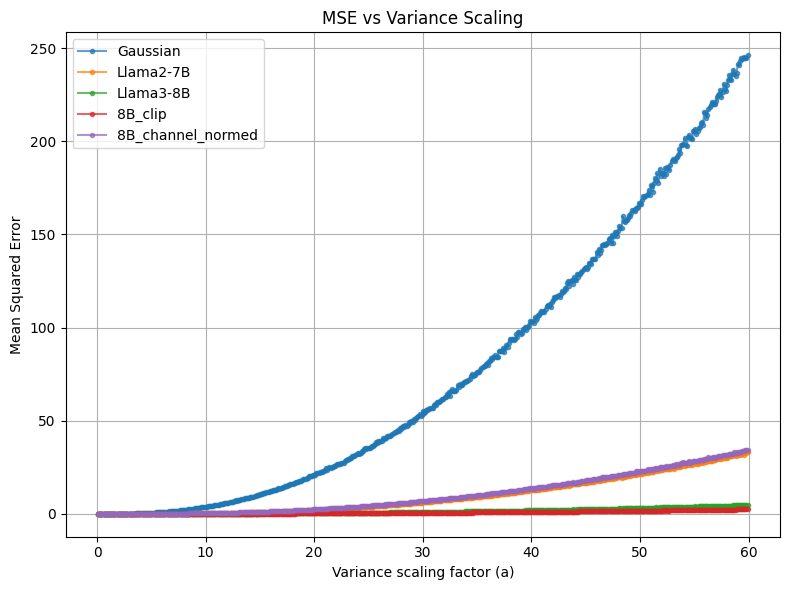

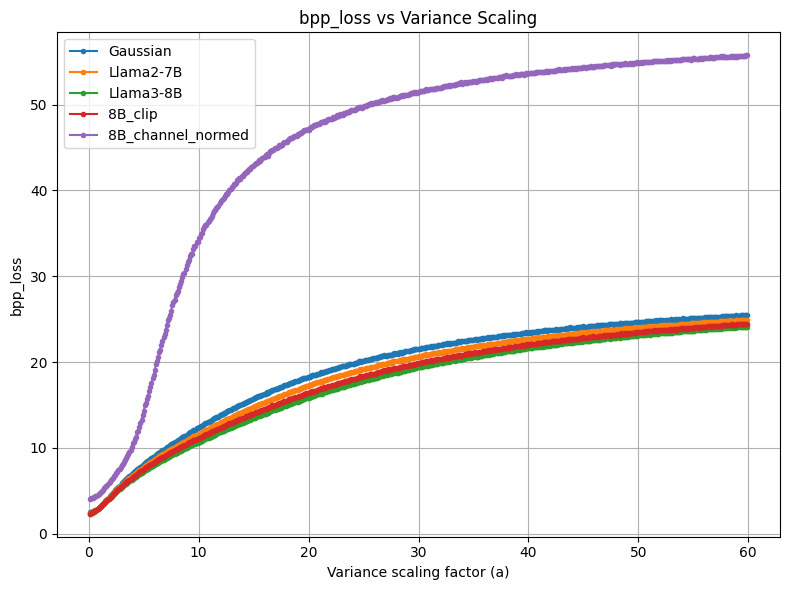

In [115]:
# Plot
plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.plot(a_values, mse_lists[i], label=comp_model_name[i], marker='o', alpha= 0.7, markersize=3)

plt.xlabel('Variance scaling factor (a)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Variance Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(models)):
    plt.plot(a_values, bpp_lists[i], label=comp_model_name[i], marker='o', markersize=3)

plt.xlabel('Variance scaling factor (a)')
plt.ylabel('bpp_loss')
plt.title('bpp_loss vs Variance Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
# values = W.T.reshape(-1, bs).max(dim= -1).values
values = W.T.reshape(-1, bs).abs().mean(dim= -1)
print(values.shape)

# NumPy로 변환
x = values.cpu().numpy()
y = col_mse_diff

x = W.flatten().abs().cpu().numpy()
y = mse.flatten().cpu().numpy()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6, s=10)
plt.xlabel('Max Value in Block')
plt.ylabel('Mean Squared Error (per Block)')
plt.title('Scatter: Max vs MSE per Block')
plt.grid(True)
plt.tight_layout()
plt.show()

torch.Size([4096])


AttributeError: 'float' object has no attribute 'flatten'

In [ ]:
fig = plt.figure()
# fig, axes = plt.subplots(len(block_sizes), 6, figsize=(24, 4 * len(block_sizes)))
ax = fig.add_subplot(111)
sc = ax.scatter(col_pca[:, 0], col_pca[:, 1], s=5, alpha=0.7, c=col_mse_block, cmap='viridis')
plt.colorbar(sc, ax=ax)  # 컬러바 추가
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True)
plt.show()

# for ax, (title, data, max_abs, errors) in zip(axs, pca_results):
#     if data is not None:
#         sc = ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7, c=errors, cmap='viridis')
#         ax.set_xlim(-max_abs, max_abs)
#         ax.set_ylim(-max_abs, max_abs)
#         plt.colorbar(sc, ax=ax)  # 컬러바 추가
#     ax.set_title(f"{idx}_{n.split('.')[-1]} ({title}) block_size {block_size}")
#     ax.set_xlabel("PC1")
#     ax.set_ylabel("PC2")
#     ax.grid(True)